In [13]:
import pandas as pd
from datetime import datetime
import sys
sys.path.insert(0,'..')
from gamma.utils import from_seconds, convert_picks_csv, association
import numpy as np
import os
from tqdm import tqdm
import time

In [14]:
catalog_dir = os.path.join("./")
if not os.path.exists(catalog_dir):
    os.makedirs(catalog_dir)
figure_dir = os.path.join("./figures")
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
station_csv = "stations.csv"
pick_json = "picks.json"
# pick_json = "picks_gamma_old.csv"
catalog_csv = "catalog_gamma.csv"
picks_csv = "picks_gamma.csv"

config = {'center': (-117.504, 35.705), 
         'xlim_degree': [-118.004, -117.004], 
         'ylim_degree': [35.205, 36.205], 
         'degree2km': 111.19492474777779, 
         'starttime': datetime(2019, 7, 4, 17, 0), 
         'endtime': datetime(2019, 7, 5, 0, 0)}
        #  'starttime': datetime(2019, 7, 4, 0, 0), 
        #  'endtime': datetime(2019, 7, 10, 0, 0)}
config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km"]
config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
config["z(km)"] = (0, 20)

## read picks
picks = pd.read_json(pick_json)
# picks = pd.read_csv(pick_json, sep="\t")
# picks = picks[["id", "timestamp", "type", "prob", "amp"]]
# picks["timestamp"] = picks["timestamp"].apply(lambda x: datetime.fromisoformat(x))
# picks["time_idx"] = picks["timestamp"].apply(lambda x: x.strftime("%Y-%m-%dT%H")) ## process by hours
picks["time_idx"] = picks["timestamp"].apply(lambda x: x.strftime("%Y-%m-%d")) ## process by days

## read stations
stations = pd.read_csv(station_csv, delimiter="\t")
stations = stations.rename(columns={"station":"id"})
stations["x(km)"] = stations["longitude"].apply(lambda x: (x - config["center"][0])*config["degree2km"])
stations["y(km)"] = stations["latitude"].apply(lambda x: (x - config["center"][1])*config["degree2km"])
stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)

### setting GMMA configs
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_amplitude"] = True
config["vel"] = {"p": 6.0, "s": 6.0 / 1.73}
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = ((config["x(km)"][0]-1, config["x(km)"][1]+1), #x
                        (config["y(km)"][0]-1, config["y(km)"][1]+1), #y
                        (0, config["z(km)"][1]+1), #x
                        (None, None)) #t
config["dbscan_eps"] = min(6, np.sqrt((stations["x(km)"].max()-stations["x(km)"].min())**2 +
                                   (stations["y(km)"].max()-stations["y(km)"].min())**2)/(6.0/1.75)) #s
config["dbscan_min_samples"] = min(3, len(stations))

# Filtering
config["min_picks_per_eq"] = min(15, len(stations) // 2)
config["max_sigma11"] = 2.0 #s
config["max_sigma22"] = 1.0 #m/s
config["max_sigma12"] = 1.0 #covariance

# print(config)
for k, v in config.items():
    print(f"{k}: {v}")

center: (-117.504, 35.705)
xlim_degree: [-118.004, -117.004]
ylim_degree: [35.205, 36.205]
degree2km: 111.19492474777779
starttime: 2019-07-04 17:00:00
endtime: 2019-07-05 00:00:00
x(km): [-55.59746237  55.59746237]
y(km): [-55.59746237  55.59746237]
z(km): (0, 20)
dims: ['x(km)', 'y(km)', 'z(km)']
use_amplitude: True
vel: {'p': 6.0, 's': 3.468208092485549}
method: BGMM
oversample_factor: 4
bfgs_bounds: ((-56.597462373888895, 56.597462373888895), (-56.597462373888895, 56.597462373888895), (0, 21), (None, None))
dbscan_eps: 6
dbscan_min_samples: 3
min_picks_per_eq: 15
max_sigma11: 2.0
max_sigma22: 1.0
max_sigma12: 1.0


In [15]:
start_time = time.time()
pbar = tqdm(sorted(list(set(picks["time_idx"]))))
event_idx0 = 0  ## current earthquake index
assignments = []
if (len(picks) > 0) and (len(picks) < 5000):
    catalogs, assignments = association(
        picks, 
        stations, 
        config,
        event_idx0,
        method=config["method"],
        pbar=pbar,
    )
    event_idx0 += len(catalogs)
else:
    catalogs = []
    for i, segment in enumerate(pbar):
        picks_ = picks[picks["time_idx"] == segment]
        if len(picks_) == 0:
            continue
        catalog, assign = association(
            picks_, 
            stations, 
            config,
            event_idx0,
            method=config["method"],
            pbar=pbar,
        )
        event_idx0 += len(catalog)
        catalogs.extend(catalog)
        assignments.extend(assign)

## create catalog
catalogs = pd.DataFrame(
    catalogs, columns=["time(s)"] + config["dims"] + ["magnitude", "sigma_time", "sigma_amp", "cov_time_amp", "event_idx", "prob_gamma"]
)
catalogs["time"] = catalogs["time(s)"].apply(lambda x: from_seconds(x))
catalogs["longitude"] = catalogs["x(km)"].apply(
    lambda x: x / config["degree2km"] + config["center"][0]
)
catalogs["latitude"] = catalogs["y(km)"].apply(
    lambda x: x / config["degree2km"] + config["center"][1]
)
catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x * 1e3)

catalogs.sort_values(by=["time"], inplace=True)
with open(catalog_csv, 'w') as fp:
    catalogs.to_csv(
        fp,
        sep="\t",
        index=False,
        float_format="%.3f",
        date_format='%Y-%m-%dT%H:%M:%S.%f',
        columns=[
            "time",
            "magnitude",
            "longitude",
            "latitude",
            "depth(m)",
            "sigma_time",
            "sigma_amp",
            "cov_time_amp",
            "event_idx",
            "prob_gamma",
            "x(km)",
            "y(km)",
            "z(km)",
        ],
    )
catalogs = catalogs[
    ['time', 'magnitude', 'longitude', 'latitude', 'depth(m)', 'sigma_time', 'sigma_amp']
]

## add assignment to picks
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gamma"])
picks = (
    picks.join(assignments.set_index("pick_idx")).fillna(-1).astype({'event_idx': int})
)
picks.sort_values(by=["timestamp"], inplace=True)
with open(picks_csv, 'w') as fp:
    picks.to_csv(
        fp,
        sep="\t",
        index=False,
        date_format='%Y-%m-%dT%H:%M:%S.%f',
        columns=["id", "timestamp", "type", "prob", "amp", "event_idx", "prob_gamma"],
    )

print(f"Total time: {time.time() - start_time} seconds")

Process 577 picks:   0%|          | 0/1 [01:39<?, ?it/s] /home/weiqiang/Research/GaMMA/tests/../gamma/_base.py:275: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
Process 28 picks: 100%|██████████| 1/1 [01:49<00:00, 109.64s/it]


Total time: 110.33855319023132 seconds


In [16]:
result_label="GaMMA"
catalog_label="SCSN"

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

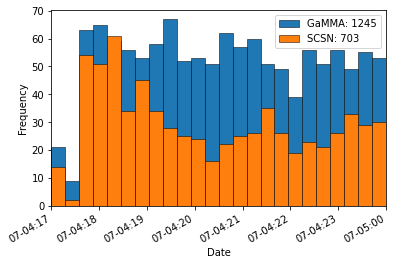

In [17]:

stations = pd.read_csv(("stations.csv"), delimiter="\t")
events = pd.read_csv(("catalog_scsn.csv"), delimiter="\t")
events["time"] = events["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))

catalog = pd.read_csv(("catalog_gamma.csv"), delimiter="\t")
catalog["time"] = catalog["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))
# catalog["covariance"] = catalog["covariance"].apply(lambda x: [float(i) for i  in x.split(",")])

plt.figure()
plt.hist(catalog["time"], range=(config["starttime"], config["endtime"]), bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{result_label}: {len(catalog['time'])}")
plt.hist(events["time"], range=(config["starttime"], config["endtime"]), bins=24, edgecolor="k", alpha=1.0, linewidth=0.5, label=f"{catalog_label}: {len(events['time'])}")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.savefig(os.path.join(figure_dir, "earthquake_number.png"), bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(figure_dir, "earthquake_number.pdf"), bbox_inches="tight")
plt.show()

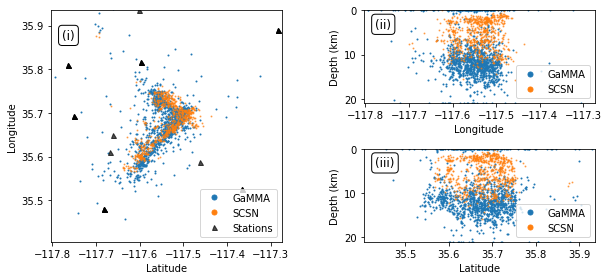

In [18]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([1.5,1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.92]
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1,1])
fig.add_subplot(grd[:, 0])
plt.plot(catalog["longitude"], catalog["latitude"], '.',markersize=2, alpha=1.0)
plt.plot(events["longitude"], events["latitude"], '.', markersize=2, alpha=0.6)
plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{result_label}", rasterized=True)
plt.plot(config["xlim_degree"][0]-10, config["ylim_degree"][0]-10, '.', markersize=10, label=f"{catalog_label}", rasterized=True)
plt.plot(stations["longitude"], stations["latitude"], 'k^', markersize=5, alpha=0.7, label="Stations")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[0, 1])
plt.plot(catalog["longitude"], catalog["depth(m)"]/1e3, '.', markersize=2, alpha=1.0, rasterized=True)
plt.plot(events["longitude"], events["depth(m)"]/1e3, '.', markersize=2, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["xlim_degree"])+np.array([0.2,-0.27]))
plt.ylim([0,21])
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["xlim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)

fig.add_subplot(grd[1, 1])
plt.plot(catalog["latitude"], catalog["depth(m)"]/1e3, '.', markersize=2, alpha=1.0, rasterized=True)
plt.plot(events["latitude"], events["depth(m)"]/1e3, '.', markersize=2, alpha=0.6, rasterized=True)
# plt.axis("scaled")
plt.xlim(np.array(config["ylim_degree"])+np.array([0.2,-0.27]))
plt.ylim([0,21])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["ylim_degree"][0]-10, 31, '.', markersize=10, label=f"{result_label}")
plt.plot(31, 31, '.', markersize=10, label=f"{catalog_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.savefig(os.path.join(figure_dir, "earthquake_location.png"), bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(figure_dir, "earthquake_location.pdf"), bbox_inches="tight", dpi=300)
plt.show()

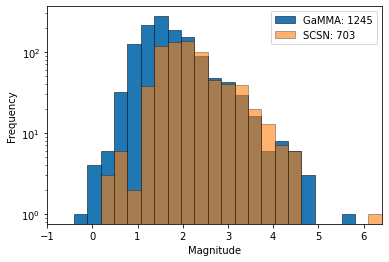

In [19]:
plt.figure()
plt.hist(catalog["magnitude"], range=(-1., events["magnitude"].max()), bins=25, alpha=1.0,  edgecolor="k", linewidth=0.5, label=f"{result_label}: {len(catalog['magnitude'])}")
plt.hist(events["magnitude"], range=(-1., events["magnitude"].max()), bins=25, alpha=0.6,  edgecolor="k", linewidth=0.5, label=f"{catalog_label}: {len(events['magnitude'])}")
plt.legend()
# plt.figure()
plt.xlim([-1,events["magnitude"].max()])
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.gca().set_yscale('log')
plt.savefig(os.path.join(figure_dir, "earthquake_magnitude_frequency.png"), bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(figure_dir, "earthquake_magnitude_frequency.pdf"), bbox_inches="tight")
plt.show()

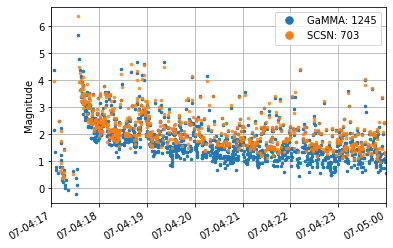

In [20]:
plt.figure()
plt.plot(catalog["time"], catalog["magnitude"], '.', markersize=5, alpha=1.0, rasterized=True)
plt.plot(events["time"], events["magnitude"], '.', markersize=5, alpha=0.8, rasterized=True)
plt.xlim(config["starttime"], config["endtime"])
ylim = plt.ylim()
plt.ylabel("Magnitude")
# plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.gca().set_prop_cycle(None)
plt.plot(config["starttime"], -10, '.', markersize=15, alpha=1.0, label=f"{result_label}: {len(catalog['magnitude'])}")
plt.plot(config["starttime"], -10, '.', markersize=15, alpha=1.0, label=f"{catalog_label}: {len(events['magnitude'])}")
plt.legend()
plt.ylim(ylim)
plt.grid()
plt.savefig(os.path.join(figure_dir, "earthquake_magnitude_time.png"), bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(figure_dir, "earthquake_magnitude_time.pdf"), bbox_inches="tight", dpi=300)
plt.show()

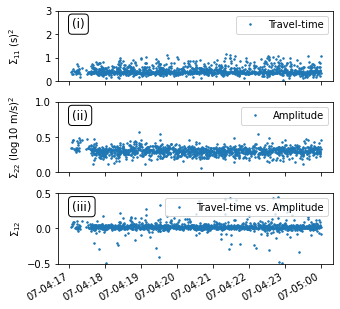

In [21]:
fig = plt.figure(figsize=plt.rcParams["figure.figsize"]*np.array([0.8,1.1]))
box = dict(boxstyle='round', facecolor='white', alpha=1)
text_loc = [0.05, 0.90]
plt.subplot(311)
plt.plot(catalog["time"], catalog["sigma_time"], '.', markersize=3.0, label="Travel-time")
plt.ylim([0, 3])
plt.ylabel(r"$\Sigma_{11}$ (s)$^2$")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(i)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(312)
plt.plot(catalog["time"], catalog["sigma_amp"], '.', markersize=3.0, label="Amplitude")
plt.ylim([0, 1])
plt.ylabel(r"$\Sigma_{22}$ ($\log10$ m/s)$^2$")
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(ii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.subplot(313)
plt.plot(catalog["time"], catalog["cov_time_amp"], '.', markersize=3.0, label="Travel-time vs. Amplitude")
plt.ylabel(r"$\Sigma_{12}$")
plt.ylim([-0.5, 0.5])
plt.legend(loc="upper right")
plt.text(text_loc[0], text_loc[1], '(iii)', horizontalalignment='left', verticalalignment="top", 
         transform=plt.gca().transAxes, fontsize="large", fontweight="normal", bbox=box)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
# plt.suptitle(r"Covariance Matrix ($\Sigma$) Coefficients")
plt.tight_layout()
plt.gcf().align_labels()
plt.savefig(os.path.join(figure_dir, "covariance.png"), bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(figure_dir, "covariance.pdf"), bbox_inches="tight")